# Star Schema Data Analysis

Explore the Instacart star schema data using PySpark. This notebook connects to Google Cloud Storage, loads Parquet tables, and demonstrates basic analysis.

## Imports

In [84]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Set up Spark session with GCS

In [52]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/yonatanhanasav/.gcp/spark-etl-key.json"
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/yonatanhanasav/.gcp/spark-etl-key.json"
gcs_jar = "/Users/yonatanhanasav/Data-Engineering-Projects/spark-star-schema-project/jars/gcs-connector-hadoop3-latest.jar"

# Set up Spark session with GCS connector
spark = (
    SparkSession.builder
    .appName("StarSchemaAnalysis")
    .config("spark.jars", gcs_jar)
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true")
    .config("spark.hadoop.fs.gs.impl", 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS')
    .config("spark.hadoop.google.cloud.auth.type", 'APPLICATION_DEFAULT')
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true")
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", os.environ["GOOGLE_APPLICATION_CREDENTIALS"])
    .getOrCreate()
)

print("Spark version:", spark.version)

Spark version: 4.0.0


## Load Parquet Tables from GCS

In [53]:
bucket = 'gs://spark-star-schema-bucket/processed/'

fact_df = spark.read.parquet(bucket + 'fact_order_products')
dim_product_df = spark.read.parquet(bucket + 'dim_product')
dim_user_df = spark.read.parquet(bucket + 'dim_user')
dim_date_df = spark.read.parquet(bucket + 'dim_date')
dim_aisle_df = spark.read.parquet(bucket + 'dim_aisle')
dim_department_df = spark.read.parquet(bucket + 'dim_department')

print('Tables loaded!')

Tables loaded!


## Explore Table Schemas and Sample Data

In [54]:
# Print schemas
fact_df.printSchema()
dim_product_df.printSchema()
dim_user_df.printSchema()
dim_date_df.printSchema()

# Show sample rows
fact_df.show(5)
dim_product_df.show(5)
dim_user_df.show(5)
dim_date_df.show(5)

root
 |-- order_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- add_to_cart_order: string (nullable = true)
 |-- reordered: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- order_number: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- date_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- is_weekend: string (nullable = true)
 |-- unit_price: string (nullable = true)
 |-- sales_amount: string (nullable = true)

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)
 |-- unit_price: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)
 |-- product_order_count: string (nullable = true)

## Top 10 Most Ordered Products

,product_id,product_name,count
0,24852,Banana,"491,291"
1,13176,Bag of Organic Bananas,"394,930"
2,21137,Organic Strawberries,"275,577"
3,21903,Organic Baby Spinach,"251,705"
4,47209,Organic Hass Avocado,"220,877"
5,47766,Organic Avocado,"184,224"
6,47626,Large Lemon,"160,792"
7,16797,Strawberries,"149,445"
8,26209,Limes,"146,660"
9,27845,Organic Whole Milk,"142,813"


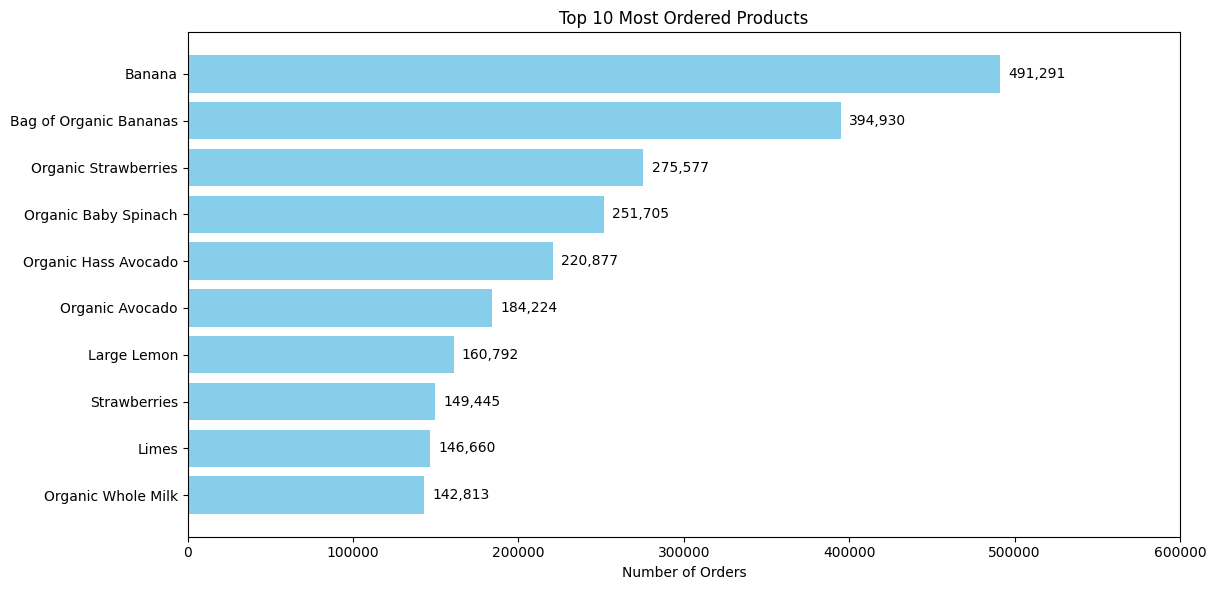

In [ ]:
# Repartition by product_id for better parallelism in groupBy
fact_df_repart = fact_df.repartition('product_id')

# Top 10 most ordered products
top_products = (
    fact_df_repart
    .groupBy('product_id')
    .count()
    .join(dim_product_df, 'product_id')
    .select('product_id', 'product_name', 'count')
    .withColumn("count", col("count").cast("int"))
    .orderBy('count', ascending=False)
    .limit(10)
)

# Show as Pandas DataFrame 
pd_df = top_products.toPandas()
pd_df['count'] = pd_df['count'].apply(lambda x: f"{x:,}")
display(pd_df)

# Ensure 'count' is integer for plotting
pd_df['count'] = pd_df['count'].replace({',': ''}, regex=True).astype(int)
plt.figure(figsize=(12, 6))
bars = plt.barh(pd_df['product_name'][::-1], pd_df['count'][::-1], color='skyblue')
plt.xlabel('Number of Orders')
plt.title('Top 10 Most Ordered Products')
plt.tight_layout()

# Set x-axis from 0 to 500,000 with identical tick intervals (e.g., every 100,000)
plt.xlim(0, 500_000)
plt.xticks(np.arange(0, 600_001, 100_000))

# Add comma-formatted value labels to the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 5000,  # small offset to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}',
        va='center', ha='left', fontsize=10
    )

plt.show()

## Sales by Top 5 Departments

,department_id,department,total_sales
0,4,produce,"112,847,856.00"
1,16,dairy eggs,"56,446,420.00"
2,19,snacks,"31,808,822.00"
3,7,beverages,"30,060,722.00"
4,1,frozen,"24,315,932.00"


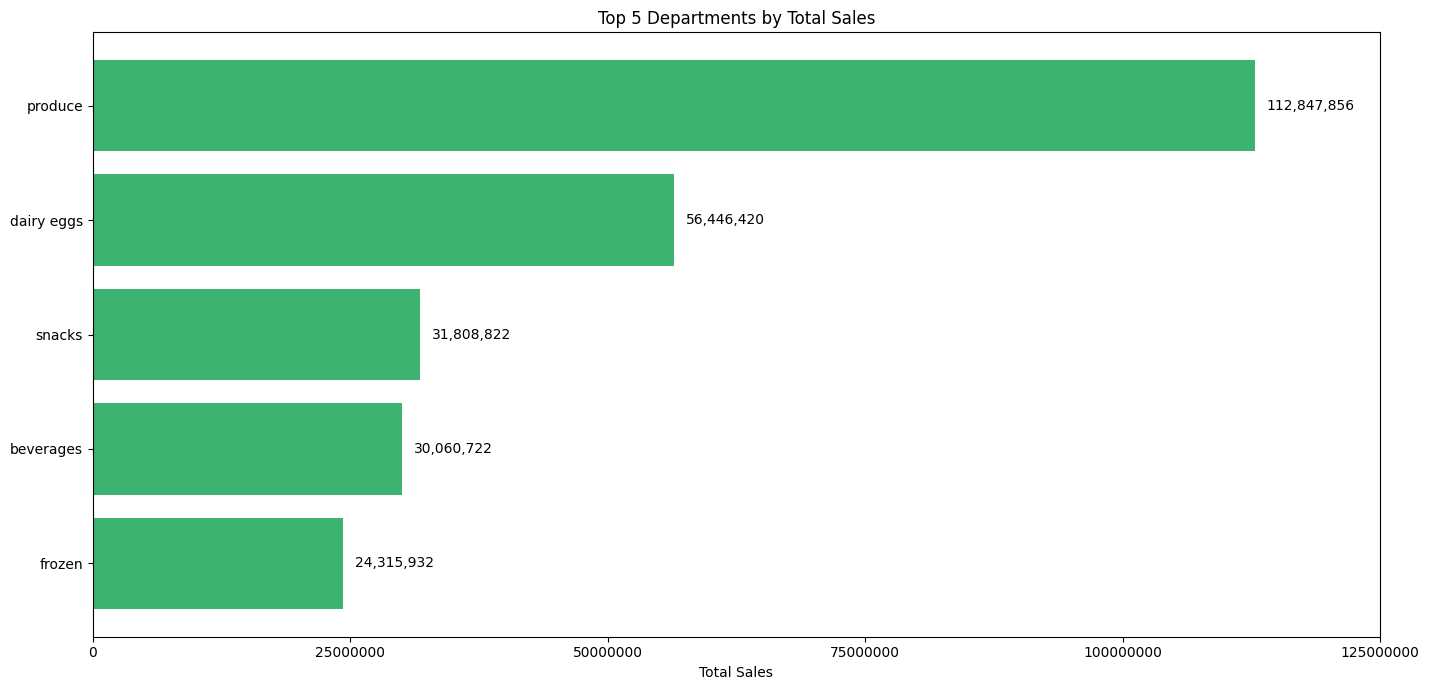

In [80]:
# Join fact table with product and department dimensions
fact_with_dept = (
    fact_df
    .join(dim_product_df.select("product_id", "department_id"), "product_id")
    .join(dim_department_df, "department_id")
)

# Repartition by department_id for better parallelism in groupBy (now department_id exists)
fact_with_dept = fact_with_dept.repartition('department_id')

# Cast sales_amount to float for aggregation
fact_with_dept = fact_with_dept.withColumn("sales_amount", col("sales_amount").cast("float"))

# Aggregate total sales by department, order, and limit to top 5
sales_by_dept = (
    fact_with_dept
    .groupBy("department_id", "department")
    .sum("sales_amount")
    .withColumnRenamed("sum(sales_amount)", "total_sales")
    .withColumn("total_sales", col("total_sales").cast("float"))
    .orderBy('total_sales', ascending=False)
    .limit(5)  # <-- Only top 5 departments
)

# Show as Pandas DataFrame
pd_df = sales_by_dept.toPandas()
pd.set_option('display.float_format', '{:,.2f}'.format)
display(pd_df)

# Plot with matplotlib
plt.figure(figsize=(14, 7))
bars = plt.barh(pd_df['department'][::-1], pd_df['total_sales'][::-1], color='mediumseagreen')
plt.xlabel('Total Sales')
plt.title('Top 5 Departments by Total Sales')
plt.tight_layout()

# Set x-axis to start at 0 and end at a rounded value above the max, with even ticks
max_sales = pd_df['total_sales'].max()
interval = 25_000_000  # 25 million per tick
xmax = (int(max_sales // interval) + 1) * interval
plt.xlim(0, xmax)
plt.xticks(np.arange(0, xmax + 1, interval))

# Make x-axis ticks plain (not scientific notation)
plt.ticklabel_format(style='plain', axis='x')

# Add comma-formatted value labels to the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max_sales * 0.01,  # small offset to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}',
        va='center', ha='left', fontsize=10
    )

plt.show()

## Number of Orders Over Time

,order_date,order_count
0,2015-01-01,302
1,2015-01-02,302
2,2015-01-03,285
3,2015-01-04,319
4,2015-01-05,341
5,2015-01-06,335
6,2015-01-07,402
7,2015-01-08,415
8,2015-01-09,434
9,2015-01-10,448


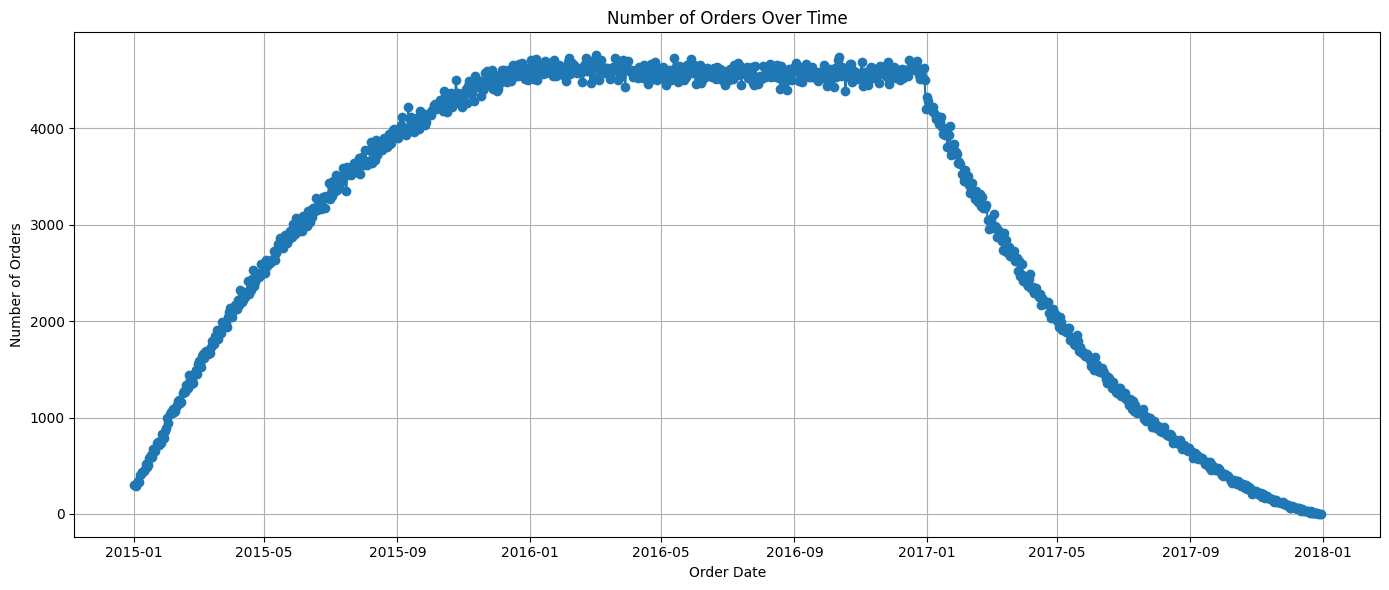

In [85]:
# Alias the DataFrames
fact_df_alias = fact_df.alias("fact")
dim_date_renamed = dim_date_df.select("date_id", col("date").alias("order_date")).alias("date")

# Join using aliases
fact_with_date = (
    fact_df_alias
    .join(dim_date_renamed, col("fact.date_id") == col("date.date_id"))
    .select(
        col("fact.date_id"),
        col("fact.order_id"),
        col("date.order_date")
    )
)

# Aggregate order count by order_date
orders_over_time = (
    fact_with_date
    .groupBy("order_date")
    .agg(countDistinct("order_id").alias("order_count"))
    .orderBy("order_date")
)

# Convert to Pandas for pretty printing and plotting
pd_orders_time = orders_over_time.toPandas()
pd_orders_time['order_date'] = pd.to_datetime(pd_orders_time['order_date'])
pd_orders_time = pd_orders_time.sort_values('order_date')

display(pd_orders_time.head(10))

# Plot line chart
plt.figure(figsize=(14, 6))
plt.plot(pd_orders_time['order_date'], pd_orders_time['order_count'], marker='o', linestyle='-')
plt.xlabel('Order Date')
plt.ylabel('Number of Orders')
plt.title('Number of Orders Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

## Most Frequently Reordered Products

In [60]:
# Filter out non-numeric reorder rates
filtered_products = dim_product_df.filter(col("product_reorder_rate").rlike(r"^\d+(\.\d+)?$"))

# Now cast and order
top_reordered = (
    filtered_products
    .withColumn("product_reorder_rate_float", col("product_reorder_rate").cast("float"))
    .orderBy(col("product_reorder_rate_float").desc())
    .select("product_id", "product_name", "product_reorder_rate_float")
)
# Convert to Pandas for pretty printing
pd_df = top_reordered.toPandas()
pd.set_option('display.float_format', '{:,.2f}'.format)
display(pd_df.head(10))

,product_id,product_name,product_reorder_rate_float
0,6433,Raw Veggie Wrappers,0.94
1,2075,Serenity Ultimate Extrema Overnight Pads,0.93
2,43553,Orange Energy Shots,0.92
3,27740,Chocolate Love Bar,0.92
4,14609,Soy Powder Infant Formula,0.91
5,13875,Simply Sleep Nighttime Sleep Aid,0.91
6,39992,"Energy Shot, Grape Flavor",0.91
7,5868,Russian River Valley Reserve Pinot Noir,0.90
8,36543,Bars Peanut Butter,0.90
9,26093,Soy Crisps Lightly Salted,0.90


## Weekend vs Weekday Sales


In [62]:
# Alias the DataFrames
fact_df_alias = fact_df.alias("fact")
dim_date_renamed = dim_date_df.select(
    "date_id",
    col("date").alias("order_date"),
    "is_weekend"  # Include is_weekend from the date dimension
).alias("date")

# Join using aliases and select all needed columns
fact_with_date = (
    fact_df_alias
    .join(dim_date_renamed, col("fact.date_id") == col("date.date_id"))
    .withColumn("sales_amount", col("fact.sales_amount").cast("float"))
    .select(
        col("fact.date_id"),
        col("fact.order_id"),
        col("fact.product_id"),
        col("fact.user_id"),
        col("sales_amount"),
        col("date.order_date"),
        col("date.is_weekend")  # Now included for aggregation
    )
)

# Aggregate sales by is_weekend
weekend_sales = (
    fact_with_date
    .groupBy("is_weekend")
    .sum("sales_amount")
    .withColumnRenamed("sum(sales_amount)", "total_sales")
    .orderBy("is_weekend")
)

# Convert to Pandas for pretty printing (optional)
pd_weekend_sales = weekend_sales.toPandas()
pd.set_option('display.float_format', '{:,.2f}'.format)
display(pd_weekend_sales)

,is_weekend,total_sales
0,False,"257,219,150.27"
1,True,"103,275,631.08"
